In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lg17cam

___
# **Image processing for sediment transport (3/3)**

## Visualize results

In [2]:
## Files of troughs and Peaks
troughs = {'name' : "Troughs",
           'path' : r"allTroughs.csv",
           'color': 'pink'}

peaks = {'name' : "Peaks",
         'path' : r"allPeaks.csv",
         'color': 'limegreen'}

# Import as pandas dataframes
for data in [troughs,peaks]:
    data['df'] = lg17cam.readProcessedPairs(data['path']) 

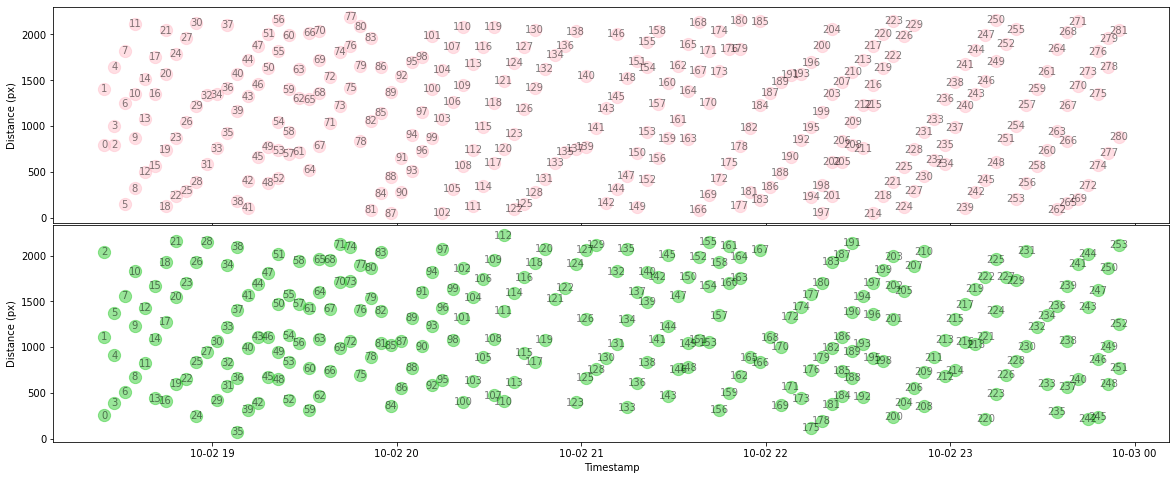

In [3]:
fig,axs = plt.subplots(2,1,figsize=[20,8],sharex=True,gridspec_kw={'hspace':0.01})

for ax,data in zip(axs,[troughs,peaks]):
    ax.scatter(data['df']['Time'],data['df']['X(px)'],s=150,c=data['color'],
               marker='o',alpha=0.5,label=data['name'])
    ax.set(ylabel='Distance (px)')
    for i,time,x in zip(data['df'].index,data['df']['Time'],data['df']['X(px)']): 
        ax.text(time,x,str(i),fontsize=10,alpha=0.5,ha='center',va='center')
ax.set(xlabel='Timestamp')
plt.show()

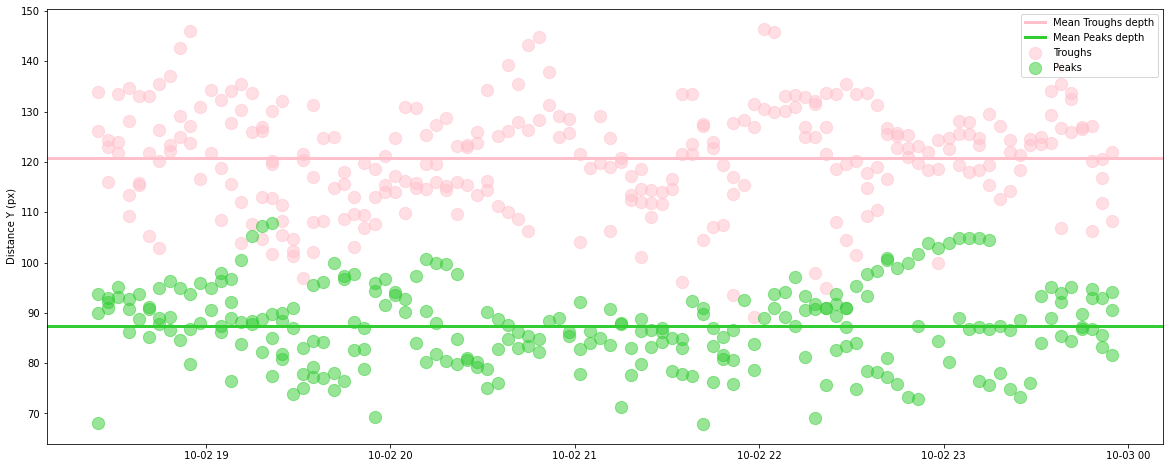

In [4]:
fig,ax = plt.subplots(figsize=[20,8],sharex=True,gridspec_kw={'hspace':0.01})

for data in [troughs,peaks]:
    ax.scatter(data['df']['Time'],data['df']['Y(px)'],s=150,c=data['color'],
               marker='o',alpha=0.5,label=data['name'])
    ax.axhline(y=data['df']['Y(px)'].mean(),c=data['color'],lw=3,label=f"Mean {data['name']} depth")

ax.set(ylabel='Distance Y (px)')
ax.legend()
plt.show()

In [5]:
troughs['df']

,I,Time,X(px),Y(px)
0,0,2021-10-02 18:24:52,796.0,134.0
1,0,2021-10-02 18:24:52,1408.0,126.2
2,1,2021-10-02 18:28:12,793.0,116.1
3,1,2021-10-02 18:28:12,999.0,124.4
4,1,2021-10-02 18:28:12,1644.0,123.0
...,...,...,...,...
277,98,2021-10-02 23:51:32,707.0,120.6
278,98,2021-10-02 23:51:32,1649.0,111.9
279,98,2021-10-02 23:51:32,1956.0,116.8
280,99,2021-10-02 23:54:52,882.0,122.0


In [6]:
peaks['df']

,I,Time,X(px),Y(px)
0,0,2021-10-02 18:24:52,256.0,93.8
1,0,2021-10-02 18:24:52,1112.0,89.9
2,0,2021-10-02 18:24:52,2041.0,68.1
3,1,2021-10-02 18:28:12,394.0,92.1
4,1,2021-10-02 18:28:12,911.0,91.0
...,...,...,...,...
249,98,2021-10-02 23:51:32,1008.0,92.9
250,98,2021-10-02 23:51:32,1866.0,83.2
251,99,2021-10-02 23:54:52,774.0,81.7
252,99,2021-10-02 23:54:52,1257.0,94.1


____
# **Clustering lines**

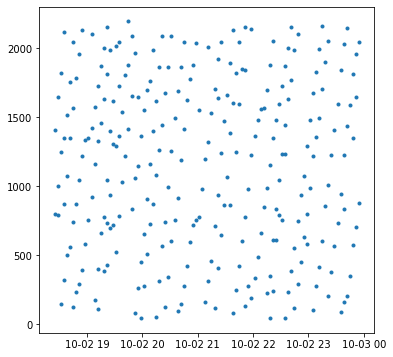

In [7]:
tds = troughs['df']

fig,ax = plt.subplots(figsize=[6,6])
ax.scatter(tds['Time'],tds['X(px)'],marker='.')
plt.show()

### Preprocessing

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
tds['xmm'] = scaler.fit_transform(tds[['X(px)']])
scaler = MinMaxScaler(feature_range=(-50, 50))
tds['tmm'] = scaler.fit_transform(tds[['I']])
tds['vmm'] = np.array([xi,yi] for xi,yi in zip(tds['tmm'],tds['xmm']))

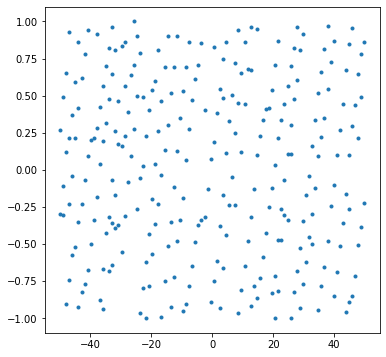

In [9]:
fig,ax = plt.subplots(figsize=[6,6])
ax.scatter(tds['tmm'],tds['xmm'],marker='.')
plt.show()

In [10]:
theta = np.deg2rad(-10)
rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
tds['vrot'] = np.array(np.dot(rot, v) for v in tds['vmm'])
tds['trot'],tds['xrot'] = [x[0] for x in tds['vrot']],[x[1] for x in tds['vrot']]

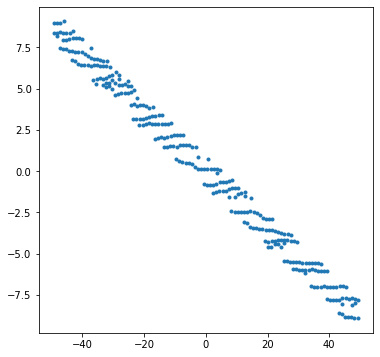

In [11]:
fig,ax = plt.subplots(figsize=[6,6])
ax.scatter(tds['trot'],tds['xrot'],marker='.')
plt.show()

In [12]:
scaler = StandardScaler()
tds['xstand'] = scaler.fit_transform(tds[['xrot']])
tds['tstand'] = scaler.fit_transform(tds[['trot']])

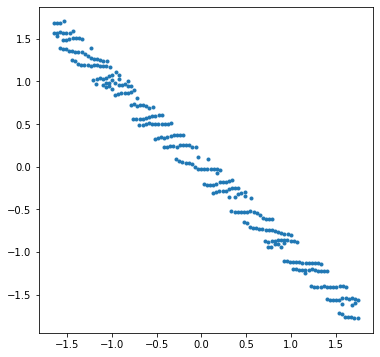

In [13]:
fig,ax = plt.subplots(figsize=[6,6])
ax.scatter(tds['tstand'],tds['xstand'],marker='.')
plt.show()

### DBSCAN

https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

In [14]:
from sklearn.cluster import DBSCAN
EPSILON_SEARCH = 0.0805
clustering = DBSCAN(eps=EPSILON_SEARCH, min_samples=5).fit(tds[['tstand','xstand']])
tds['labels'] = clustering.labels_

In [15]:
#For pretty coloring
import matplotlib.colors as colors
import matplotlib.cm as cmx
scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=tds['labels'].max()),
                               cmap=plt.get_cmap('prism'))

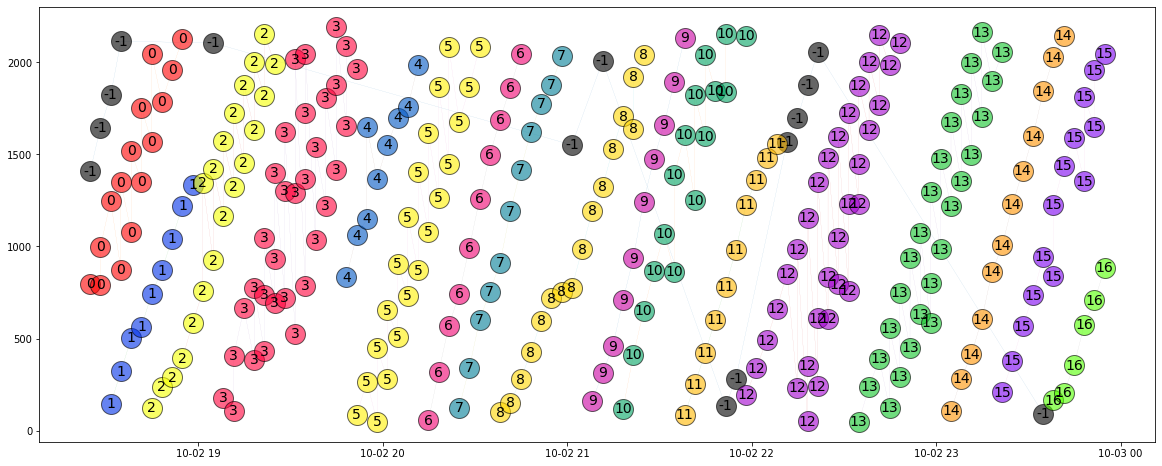

In [18]:
fig,ax = plt.subplots(figsize=[20,8])
for ng,group in tds.groupby("labels"):
    c = (scalarMap.to_rgba(ng),'k')[ng == -1]
    ax.plot(group['Time'],group['X(px)'],lw=0.1,ms=20,marker='o',mfc=c,mec='k',alpha=0.6)
    
    for time,x in zip(group['Time'],group['X(px)']): 
        ax.text(time,x,str(ng),fontsize=14,ha='center',va='center')

plt.show()

In [19]:
tds.groupby('labels').count()

,I,Time,X(px),Y(px),xmm,tmm,vmm,vrot,trot,xrot,xstand,tstand
labels,,,,,,,,,,,,
-1,14,14,14,14,14,14,14,14,14,14,14,14
0,15,15,15,15,15,15,15,15,15,15,15,15
1,9,9,9,9,9,9,9,9,9,9,9,9
2,20,20,20,20,20,20,20,20,20,20,20,20
3,32,32,32,32,32,32,32,32,32,32,32,32
4,9,9,9,9,9,9,9,9,9,9,9,9
5,21,21,21,21,21,21,21,21,21,21,21,21
6,10,10,10,10,10,10,10,10,10,10,10,10
7,11,11,11,11,11,11,11,11,11,11,11,11


In [28]:
from scipy.stats import linregress

regressions = []
for ng,group in tds.groupby('labels'):
    if ng > -1:
        regressions.append(linregress(group['I'], group['X(px)']))

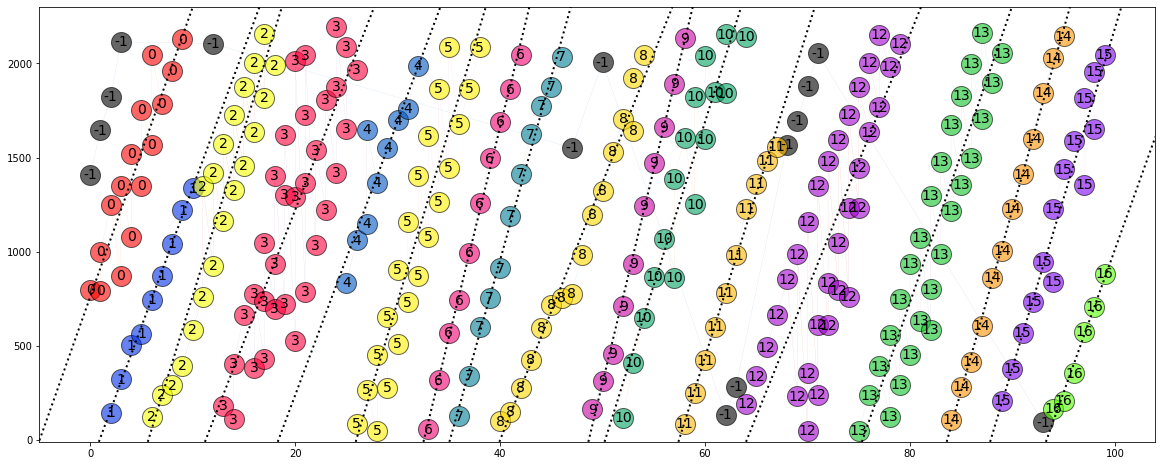

In [38]:
fig,ax = plt.subplots(figsize=[20,8])

for ng,group in tds.groupby("labels"):
    c = (scalarMap.to_rgba(ng),'k')[ng == -1]
    ax.plot(group['I'],group['X(px)'],lw=0.1,ms=20,marker='o',mfc=c,mec='k',alpha=0.6)
    
    for time,x in zip(group['I'],group['X(px)']): 
        ax.text(time,x,str(ng),fontsize=14,ha='center',va='center')

for reg in regressions:
    ax.axline((0,reg.intercept), slope = reg.slope, lw=2, c='k', ls='dotted')
ax.set(ylim=[-10,2300])
plt.show()

In [39]:
regressions[10]

LinregressResult(slope=173.35172895564094, intercept=-8711.359762486902, rvalue=0.94355549135613, pvalue=4.213082593900934e-08, stderr=16.263201167467113, intercept_stderr=945.8470731731228)